In [ ]:
https://chatgpt.com/share/68d4151b-a424-800e-b7ba-090b7c038ed1

In [4]:
# Cell 1: Install dependencies
%pip install opencv-python pillow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install imagehash

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Cell 2: Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import imagehash

In [7]:
# Cell 3: Utility - show image
def show(img, title="Image", cmap=None):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape)==3 else img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [8]:
# Cell 4: ORB Keypoint Copy-Move Detection
def detect_copy_move_orb(image, min_match_count=20):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB_create(nfeatures=2000)
    keypoints, descriptors = orb.detectAndCompute(gray, None)

    if descriptors is None or len(keypoints) < 2:
        return image, 0

    # Match descriptors with themselves
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors, descriptors)

    suspicious_matches = []
    h, w = gray.shape
    for m in matches:
        if m.queryIdx == m.trainIdx:
            continue
        pt1 = keypoints[m.queryIdx].pt
        pt2 = keypoints[m.trainIdx].pt
        dist = np.linalg.norm(np.array(pt1) - np.array(pt2))
        if 20 < dist < min(h, w)/2:  # avoid too close or too far
            suspicious_matches.append((pt1, pt2))

    output = image.copy()
    for (x1, y1), (x2, y2) in suspicious_matches:
        cv2.circle(output, (int(x1), int(y1)), 5, (0,0,255), 2)
        cv2.circle(output, (int(x2), int(y2)), 5, (255,0,0), 2)
        cv2.line(output, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 1)

    return output, len(suspicious_matches)


In [9]:
# Cell 5: Block-based Patch Detection (pHash)
def detect_copy_move_blocks(image, block_size=64, step=32, threshold=5):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape

    blocks = []
    positions = []

    # extract blocks with overlap
    for y in range(0, h-block_size, step):
        for x in range(0, w-block_size, step):
            crop = Image.fromarray(gray[y:y+block_size, x:x+block_size])
            hval = imagehash.phash(crop)
            blocks.append(hval)
            positions.append((x,y))

    suspicious_pairs = []
    for i in range(len(blocks)):
        for j in range(i+1, len(blocks)):
            if abs(blocks[i]-blocks[j]) <= threshold:
                (x1,y1), (x2,y2) = positions[i], positions[j]
                suspicious_pairs.append(((x1,y1), (x2,y2)))

    output = image.copy()
    for (x1,y1), (x2,y2) in suspicious_pairs:
        cv2.rectangle(output, (x1,y1), (x1+block_size,y1+block_size), (0,0,255), 2)
        cv2.rectangle(output, (x2,y2), (x2+block_size,y2+block_size), (255,0,0), 2)

    return output, len(suspicious_pairs)


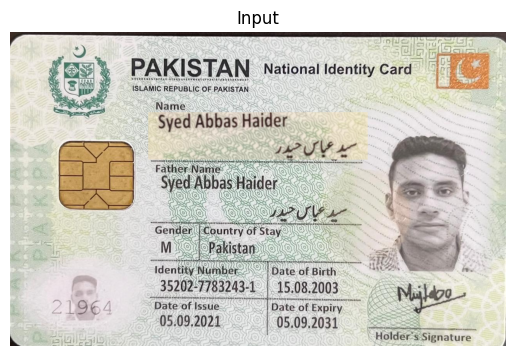

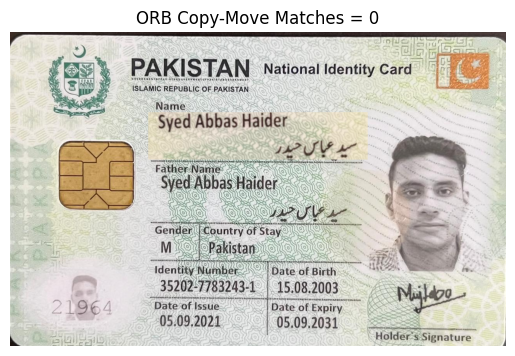

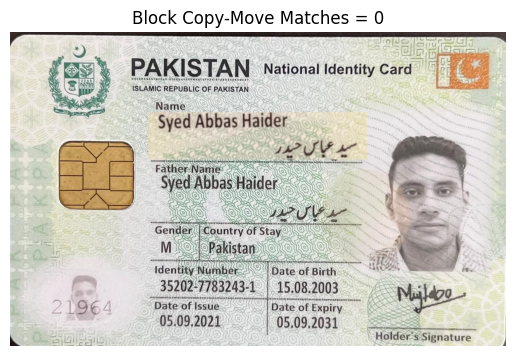

========= COPY-MOVE TAMPERING DECISION =========
ORB method:   REAL (clean) | Matches = 0
Block method: REAL (clean) | Matches = 0

Final Verdict: ✅ REAL (No strong tampering detected)


In [12]:
# Cell 6: Run Detection on a Tampered Image
img_path = r"C:\Users\mujta\Downloads\me.png"   # change this to your test image
image = cv2.imread(img_path)

show(image, "Input")

# ORB method
orb_out, orb_count = detect_copy_move_orb(image)
orb_fake = orb_count > 25   # threshold
show(orb_out, f"ORB Copy-Move Matches = {orb_count}")

# Block-hash method
block_out, block_count = detect_copy_move_blocks(image)
block_fake = block_count > 10  # threshold
show(block_out, f"Block Copy-Move Matches = {block_count}")

# Final decision
print("========= COPY-MOVE TAMPERING DECISION =========")
print(f"ORB method:   {'FAKE (tampered)' if orb_fake else 'REAL (clean)'} | Matches = {orb_count}")
print(f"Block method: {'FAKE (tampered)' if block_fake else 'REAL (clean)'} | Matches = {block_count}")

if orb_fake or block_fake:
    print("\nFinal Verdict: ❌ FAKE (Document is likely altered)")
else:
    print("\nFinal Verdict: ✅ REAL (No strong tampering detected)")



In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

def error_level_analysis(path, quality=90, threshold=15):
    if not os.path.exists(path):
        raise FileNotFoundError(f"❌ File not found: {path}")

    original = cv2.imread(path)
    if original is None:
        raise ValueError(f"❌ Could not load image: {path}")

    # Recompress at given quality
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    success, encoded = cv2.imencode(".jpg", original, encode_param)
    if not success:
        raise RuntimeError("❌ JPEG compression failed.")

    compressed = cv2.imdecode(encoded, 1)
    if compressed is None:
        raise RuntimeError("❌ Failed to decode compressed image.")

    # Difference map
    diff = cv2.absdiff(original, compressed)
    diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    norm = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)

    # Tampering decision
    score = np.mean(norm)
    verdict = "FAKE (tampered)" if score > threshold else "REAL (clean)"

    return original, norm, score, verdict


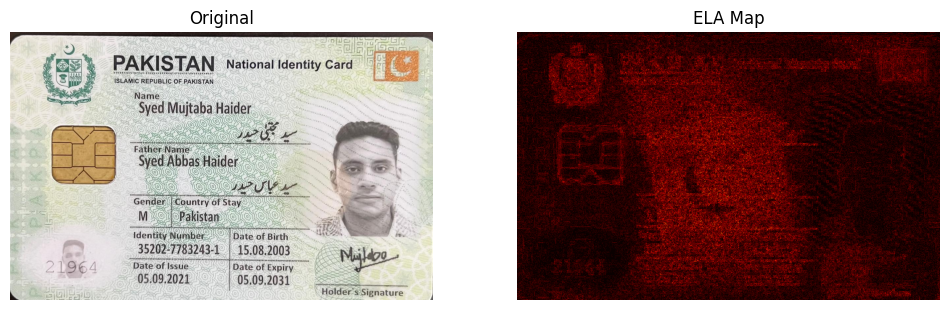

========= ELA TAMPERING DECISION =========
ELA Score (mean intensity): 17.70
Final Verdict: FAKE (tampered)


In [18]:
img_path = r"C:\Users\mujta\OneDrive\Desktop\Front ID Card - Mujtaba.jpeg"  # your patched ID

orig, ela, score, verdict = error_level_analysis(img_path)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(ela, cmap='hot')
plt.title("ELA Map")
plt.axis("off")
plt.show()

print("========= ELA TAMPERING DECISION =========")
print(f"ELA Score (mean intensity): {score:.2f}")
print(f"Final Verdict: {verdict}")


In [19]:
import cv2
import numpy as np
import os

def error_level_analysis(path, quality=90, global_thresh=25, local_thresh=40):
    if not os.path.exists(path):
        raise FileNotFoundError(f"❌ File not found: {path}")

    original = cv2.imread(path)
    if original is None:
        raise ValueError(f"❌ Could not load image: {path}")

    # Recompress
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    success, encoded = cv2.imencode(".jpg", original, encode_param)
    if not success:
        raise RuntimeError("❌ JPEG compression failed.")

    compressed = cv2.imdecode(encoded, 1)

    diff = cv2.absdiff(original, compressed)
    diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    norm = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)

    # Metrics
    mean_intensity = np.mean(norm)
    max_intensity = np.max(norm)

    # Decision rules
    if mean_intensity > global_thresh or max_intensity > local_thresh:
        verdict = "FAKE (tampered)"
    else:
        verdict = "REAL (clean)"

    return original, norm, mean_intensity, max_intensity, verdict


In [21]:
img_path = r"C:\Users\mujta\OneDrive\Desktop\Front ID Card - Mujtaba.jpeg"  # your clean ID

orig, ela, mean_val, max_val, verdict = error_level_analysis(img_path)

print("========= ELA TAMPERING DECISION =========")
print(f"Mean ELA Intensity: {mean_val:.2f}")
print(f"Max ELA Intensity: {max_val:.2f}")
print(f"Final Verdict: {verdict}")


========= ELA TAMPERING DECISION =========
Mean ELA Intensity: 17.70
Max ELA Intensity: 255.00
Final Verdict: FAKE (tampered)
